In [1]:
from __future__ import print_function
import cobra
from matplotlib import pyplot as plt

import os
import pandas as pd
import numpy as np


In [2]:
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 3

In [3]:
model_cons = cobra.io.load_json_model('../resources/glycolysis_ppp_tca_etc_model.json')

## A) Revisiting old assumptions
### 1) Set the objective to ATPM and optimize

In [4]:
model_cons.objective = 'ATPM'
model_cons.optimize()

,fluxes,reduced_costs
NADH2_u10mi,1.000000e+01,3.552714e-15
SUCD1m,2.000000e+00,-4.440892e-15
FADH2ETC,2.000000e+00,7.993606e-15
CYOR_u10mi,1.200000e+01,-8.881784e-15
CYOOm2i,6.000000e+00,-4.440892e-15
...,...,...
SPODM,0.000000e+00,0.000000e+00
GTHPi,0.000000e+00,-4.200000e+00
GTHOr,0.000000e+00,4.440892e-16
EX_r5p_c,0.000000e+00,-4.400000e+01


### 2) Assess the cause of the decrease in ATP yield
Using the glycolysis model and the `pyr_to_ATP` and `NADH_to_ATP` pseudo-reactions, the computed yield was 32 ATP per glucose

Use the `h_i` metabolite's `summary` method to find the reactions producing and consumine the high energy protons

In [5]:
model_cons.metabolites.h_i.summary()

## B) Modeling alternative pathways

### 1) Characterize the consequence of using each of the "extreme" options

Knock out PGI and optimize for ATPM flux. Display the fluxes through the following reactions:

| ID      | Interpretation 
| :-------------: |:-------------:|
| ATPM | ATP production potential |
| GTHOr | NADPH produced | 
| EX_h_c | Protons produced    | 
| EX_co2_c | CO$_2$ produced     | 
| EX_h2o_c | Water produced     | 

Repeat analysis with G6PDH2r knocked out

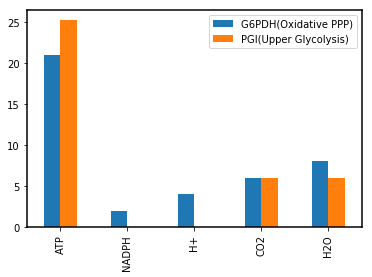

In [21]:
model = model_cons.copy()

with model:
    model.reactions.PGI.knock_out()
    sol=model.optimize()
    series1 = sol.fluxes[['ATPM', 'GTHOr', 'EX_h_c', 'EX_co2_c', 'EX_h2o_c']]
    series1.name = 'G6PDH(Oxidative PPP)'

with model:
    model.reactions.G6PDH2r.knock_out()

    sol = model.optimize()
    series2 = sol.fluxes[['ATPM', 'GTHOr', 'EX_h_c', 'EX_co2_c', 'EX_h2o_c']]
    series2.name = 'PGI(Upper Glycolysis)'

df = pd.DataFrame([series1, series2])
df.columns = ['ATP', 'NADPH', 'H+', 'CO2', 'H2O']
df.abs().T.plot(kind='bar')

### 2) Characterizing the solution space: Flux variability analysis (FVA)

Maximize and minimize the flux through G6PDH2r and PGI for values of ATPM form 0 to the maximum values
 - **Note** minimization is performed by passing 'minimize' into `optimize` method
 
Use the `plot_fva` to visualize results. Store the outpus in lists corresponding to those in `plot_fva`.

In [18]:
def plot_fva(atpm_values, max_g6pdh_values, max_pgi_values, min_g6pdh_values, min_pgi_values):
    """
    Parameters
    ----------
    atpm_values : list
        list of ATPM flux values from 0 to max
        
    max_g6pdh_values : list
        list of maximum G6PDH2r flux values at the ATPM fluxes in atpm_values
    max_pgi_values : list
        list of maximum PGI flux values at the ATPM fluxes in atpm_values

    min_g6pdh_values : list 
        list of minimum G6PDH2r flux values at the ATPM fluxes in atpm_values

    min_pgi_values : list
        list of minimum PGI flux values at the ATPM fluxes in atpm_values

    """
    plt.fill_between(atpm_values, max_g6pdh_values, min_g6pdh_values, 
                     label='G6PDH(ppp)', alpha=.7)
    plt.fill_between(atpm_values, max_pgi_values, min_pgi_values, 
                     label='PGI(glycolysis)', alpha=.7)
    plt.legend()
    plt.xlabel('ATPM flux')
    plt.ylabel('Range of possible fluxes')

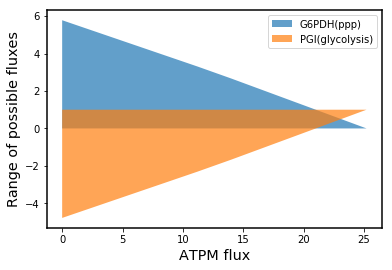

In [17]:
combined = model_cons.copy()
rxn = 'ATPM'
var_rxn = 'G6PDH2r'
var_rxn_2 = 'PGI'
combined.objective = rxn
obj = combined.optimize().objective_value
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).lower_bound = bound
    combined.reactions.get_by_id(rxn).upper_bound = bound

    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

### 3) Characterizing solution space (sampling)

Use the `cobra.sampling` method to sample the model 1000 times.

**Note**: this returns a dataframe. You can view the solutions with 

In [27]:
cobra.sampling

<module 'cobra.sampling' from '/Users/coltonlloyd/Envs/qbio18/lib/python3.6/site-packages/cobra/sampling/__init__.py'>

In [28]:
combined =model_cons.copy()
df = cobra.sampling.sample(combined, 1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12bb164a8>,
      dtype=object)

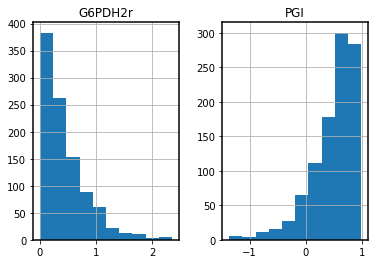

In [29]:
df[['G6PDH2r', 'PGI']].hist()

Text(0.5,0,'PGI flux')

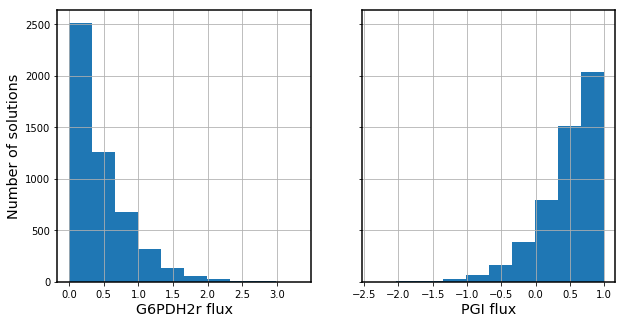

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['G6PDH2r'].hist(ax=ax)
ax.set_xlabel('G6PDH2r flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['PGI'].hist()
ax.set_xlabel('PGI flux')